Mount to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Path directory

In [ ]:
import os
BASE_DIR = '/content/drive/MyDrive/ImageCaptionGenerator/'
DATASET_DIR = os.path.join(BASE_DIR, 'Flickr8k_Dataset/')
TEXT_DIR = os.path.join(BASE_DIR, 'Flickr8k_text/')



Download the dataset

In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip Flickr8k_Dataset.zip -d /content/drive/MyDrive/ImageCaptionGenerator/
!unzip Flickr8k_text.zip -d /content/drive/MyDrive/ImageCaptionGenerator/


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/ImageCaptionGenerator/__MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: /content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: /content/drive/MyDrive/ImageCaptionGenerator/__MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: /content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: /content/drive/MyDrive/ImageCaptionGenerator/__MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: /content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: /content/drive/MyDrive/ImageCaptionGenerator/__MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: /content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: /content/drive/MyDrive/ImageCaptionGenerator/__MACOSX/Flicke

Removing unwanted captions


In [ ]:
import os
import string
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Input, Dropout, add
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from pickle import dump, load

def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

def load_descriptions(doc):
    mapping = {}
    for line in doc.split('\n'):
        tokens = line.split()
        if len(tokens) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = []
        mapping[image_id].append(image_desc)
    return mapping

def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word) > 1 and word.isalpha()]
            desc_list[i] = ' '.join(desc)

def save_descriptions(descriptions, filename):
    lines = []
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(f'{key}\t{desc}')
    data = '\n'.join(lines)
    with open(filename, 'w') as file:
        file.write(data)


TEXT_DIR = '/content/drive/MyDrive/ImageCaptionGenerator'
BASE_DIR = TEXT_DIR

filename = os.path.join(TEXT_DIR, 'Flickr8k.token.txt')
doc = load_doc(filename)
descriptions = load_descriptions(doc)

clean_descriptions(descriptions)


save_descriptions(descriptions, os.path.join(BASE_DIR, 'descriptions.txt'))


In [ ]:
def to_vocab(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc
vocab = to_vocab(descriptions)
print(f'Vocabulary Size: {len(vocab)}')

Vocabulary Size: 8763


Load the dataset

In [ ]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = set()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.add(identifier)
    return dataset

def to_lines(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

train = load_set(os.path.join(TEXT_DIR, '/content/drive/MyDrive/ImageCaptionGenerator/Flickr_8k.trainImages.txt'))
train_descriptions = {k: descriptions[k] for k in train}
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open(os.path.join(BASE_DIR, 'tokenizer.pkl'), 'wb'))

vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary Size: {vocab_size}')

max_length = max(len(d.split()) for d in to_lines(descriptions))
print(f'Description Length: {max_length}')

Vocabulary Size: 7577
Description Length: 32


Extracting the images

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
import numpy as np

def extract_features(directory):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    features = {}
    image_dir = os.path.join(directory, '/content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset')
    for name in os.listdir(image_dir):
        filename = os.path.join(image_dir, name)
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature
    return features

features = extract_features(DATASET_DIR)
dump(features, open(os.path.join(BASE_DIR, 'features.pkl'), 'wb'))

Define the model

In [ ]:
from keras.layers import Embedding, LSTM, Dense, Input, Dropout, add
from keras.models import Model

def define_model(vocab_size, max_length):

    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)


    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)


    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)


    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model


model = define_model(vocab_size, max_length)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 32, 256)              1939712   ['input_7[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 4096)                 0         ['input_6[0][0]']             
                                                                                            

Data generation

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

def data_generator(descriptions, photos, tokenizer, max_length, batch_size=32):
    while 1:
        batch_photos = []
        batch_in_seq = []
        batch_out_seq = []
        for key, desc_list in descriptions.items():
            photo = photos[key][0]
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    batch_photos.append(photo)
                    batch_in_seq.append(in_seq)
                    batch_out_seq.append(out_seq)

                    if len(batch_photos) == batch_size:
                        yield [[np.array(batch_photos), np.array(batch_in_seq)], np.array(batch_out_seq)]
                        batch_photos = []
                        batch_in_seq = []
                        batch_out_seq = []


Iterating and train the model

In [ ]:
from keras.callbacks import ModelCheckpoint
from pickle import load, dump


tokenizer = load(open(os.path.join(BASE_DIR, 'tokenizer.pkl'), 'rb'))
features = load(open(os.path.join(BASE_DIR, 'features.pkl'), 'rb'))

model = define_model(vocab_size, max_length)

epochs = 60


steps = len(train_descriptions) // 32


val_split = 0.1
val_descriptions = {k: train_descriptions[k] for k in list(train_descriptions)[:int(len(train_descriptions) * val_split)]}
train_descriptions = {k: train_descriptions[k] for k in list(train_descriptions)[int(len(train_descriptions) * val_split):]}

train_generator = data_generator(train_descriptions, features, tokenizer, max_length)
val_generator = data_generator(val_descriptions, features, tokenizer, max_length)
val_steps = len(val_descriptions) // 32

checkpoint = ModelCheckpoint(os.path.join(BASE_DIR, 'model.h5'), save_best_only=True, monitor='val_loss', mode='min')


model.fit(train_generator, validation_data=val_generator, validation_steps=val_steps, epochs=epochs, steps_per_epoch=steps, verbose=1, callbacks=[checkpoint])


Epoch 1/60
187/187 [==============================] - ETA: 0s - loss: 6.8069

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


187/187 [==============================] - 80s 365ms/step - loss: 6.8069 - val_loss: 6.2601
Epoch 2/60
187/187 [==============================] - 63s 338ms/step - loss: 6.2980 - val_loss: 6.1418
Epoch 3/60
187/187 [==============================] - 68s 366ms/step - loss: 6.2035 - val_loss: 6.1616
Epoch 4/60
187/187 [==============================] - 62s 332ms/step - loss: 6.1711 - val_loss: 5.9567
Epoch 5/60
187/187 [==============================] - 61s 324ms/step - loss: 6.1181 - val_loss: 6.1990
Epoch 6/60
187/187 [==============================] - 63s 335ms/step - loss: 5.8700 - val_loss: 6.2608
Epoch 7/60
187/187 [==============================] - 64s 343ms/step - loss: 5.8644 - val_loss: 5.5892
Epoch 8/60
187/187 [==============================] - 61s 325ms/step - loss: 5.7380 - val_loss: 5.8358
Epoch 9/60
187/187 [==============================] - 61s 326ms/step - loss: 5.5979 - val_loss: 5.3910
Epoch 10/60
187/187 [==============================] - 67s 360ms/step - loss: 5.5124

Saving the model

In [ ]:
from keras.models import load_model

tokenizer = load(open(os.path.join(BASE_DIR, 'tokenizer.pkl'), 'rb'))
features = load(open(os.path.join(BASE_DIR, 'features.pkl'), 'rb'))
model = load_model(os.path.join(BASE_DIR, 'model.h5'))


Save the Progress

In [ ]:

dump(tokenizer, open(os.path.join(BASE_DIR, 'tokenizer.pkl'), 'wb'))
dump(features, open(os.path.join(BASE_DIR, 'features.pkl'), 'wb'))
model.save(os.path.join(BASE_DIR, 'model.h5'))


tokenizer = load(open(os.path.join(BASE_DIR, 'tokenizer.pkl'), 'rb'))
features = load(open(os.path.join(BASE_DIR, 'features.pkl'), 'rb'))
model = load_model(os.path.join(BASE_DIR, 'model.h5'))


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Preprocess the Images

In [ ]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

def preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image


image_path = '/content/drive/MyDrive/flower.jpeg'
processed_image = preprocess_image(image_path)


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

def define_feature_extractor():

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

feature_extractor_model = define_feature_extractor()


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
def extract_features(image_path, feature_extractor_model):

    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)


    features = feature_extractor_model.predict(image)
    print(f'Feature vector shape: {features.shape}')
    return features


Extracting Model

In [ ]:
def extract_features(image_path, feature_extractor_model):
    try:
        print(f'Loading image from: {image_path}')
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)


        features = feature_extractor_model.predict(image)
        print(f'Feature vector shape: {features.shape}')
        return features
    except Exception as e:
        print(f'Error: {e}')


In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
import numpy as np

def create_feature_extractor():
    base_model = VGG16(weights='imagenet', include_top=True)
    model = Model(inputs=base_model.inputs, outputs=base_model.get_layer('fc2').output)

def extract_features(image_path, feature_extractor_model):
    try:

        print(f'Loading image from: {image_path}')
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)


        features = feature_extractor_model.predict(image)
        print(f'Feature vector shape: {features.shape}')
        return features
    except Exception as e:
        print(f'Error: {e}')
        return None

feature_extractor_model = create_feature_extractor()


Generating Captions

In [ ]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

def generate_caption(model, image_path, tokenizer, max_length, feature_extractor_model):

    photo = extract_features(image_path, feature_extractor_model)


    if photo is None:
        print("Error: Could not extract features from the image.")
        return ""


    if photo.shape != (1, 4096):
        print(f"Warning: Unexpected feature vector shape: {photo.shape}. Expected (1, 4096).")
        return ""


    caption = 'startseq'

    for _ in range(max_length):

        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)


        y_pred = model.predict([photo, sequence], verbose=0)
        y_pred = np.argmax(y_pred)


        word = tokenizer.index_word.get(y_pred, None)


        if word is None or word == 'endseq':
            break

        caption += ' ' + word

   caption = caption.replace('startseq', '').replace('endseq', '').strip()
    return caption


image_path='/content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset/1056249424_ef2a2e041c.jpg'

generated_caption = generate_caption(model, image_path, tokenizer, max_length, feature_extractor_model)
print(generated_caption)


1/1 [==============================] - 1s 545ms/step
Feature vector shape: (1, 512)



List of Directory

In [ ]:
import os

directory = '/content/drive/MyDrive/ImageCaptionGenerator/'
files = os.listdir(directory)

print("Files in directory:")
for file in files:
    print(file)


Files in directory:
fees receipt.pdf
sign_shivaraj.jpg
Flicker8k_Dataset
__MACOSX
CrowdFlowerAnnotations.txt
ExpertAnnotations.txt
Flickr8k.lemma.token.txt
Flickr8k.token.txt
Flickr_8k.devImages.txt
Flickr_8k.testImages.txt
Flickr_8k.trainImages.txt
readme.txt
descriptions.txt
tokenizer.pkl
features.pkl
model.h5


Next day new run

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import os
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from pickle import load


BASE_DIR = '/content/drive/MyDrive/ImageCaptionGenerator/'
model_path = os.path.join(BASE_DIR, 'model.h5')
tokenizer_path = os.path.join(BASE_DIR, 'tokenizer.pkl')
features_path = os.path.join(BASE_DIR, 'features.pkl')


model = load_model(model_path)
print("Model loaded successfully.")


tokenizer = load(open(tokenizer_path, 'rb'))
print("Tokenizer loaded successfully.")

features = load(open(features_path, 'rb'))
print("Features loaded successfully.")


Model loaded successfully.
Tokenizer loaded successfully.
Features loaded successfully.


Extracting Features

In [ ]:
def extract_features(image_path, feature_extractor_model):
    from keras.applications.vgg16 import VGG16, preprocess_input
    from keras.preprocessing.image import load_img, img_to_array
    import numpy as np


    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    features = feature_extractor_model.predict(image)


    features = np.reshape(features, (features.shape[0], -1))

    print(f'Feature vector shape: {features.shape}')
    return features

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

base_model = VGG16()

feature_extractor_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)


553467096/553467096 [==============================] - 8s 0us/step


Generating Captions

In [ ]:
from types import new_class
def generate_caption(model, image_path, tokenizer, max_length, feature_extractor_model):

    photo = extract_features(image_path, feature_extractor_model)


    photo = np.reshape(photo, (1, 4096))

    caption = 'startseq'

    for _ in range(max_length):

        sequence = tokenizer.texts_to_sequences([caption])[0]

        sequence = pad_sequences([sequence], maxlen=32)


        y_pred = model.predict([photo, sequence], verbose=0)
        y_pred = np.argmax(y_pred)


        word = tokenizer.index_word.get(y_pred, None)


        if word is None or word == 'endseq':
            break

        caption += ' ' + word


    caption = caption.replace('startseq', '').replace('endseq', '').strip()
    return caption


image_path = '/content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset/1009434119_febe49276a.jpg'
#image_path='/content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset/1022454428_b6b660a67b.jpg'
#image_path='/content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset/1056249424_ef2a2e041c.jpg'
#image_path='/content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset/1191338263_a4fa073154.jpg'

generated_caption = generate_caption(model, image_path, tokenizer, 10, feature_extractor_model)



print(generated_caption)

1/1 [==============================] - 1s 788ms/step
Feature vector shape: (1, 4096)
dog is running through the grass with young ball 

In [ ]:
pip install transformers torch


In [ ]:
!pip install transformers torch pillow requests matplotlib


In [ ]:
!pip install transformers==4.30.2 torch pillow requests matplotlib


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


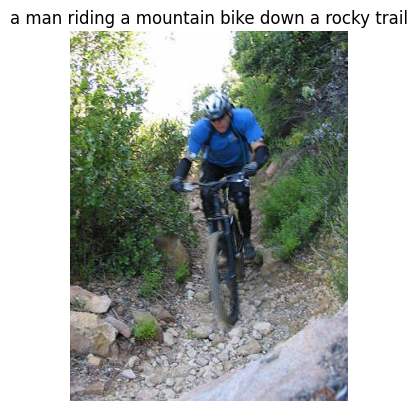

Generated caption: a man riding a mountain bike down a rocky trail


In [ ]:

!pip install transformers torch pillow requests matplotlib


from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import matplotlib.pyplot as plt


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load an image from your local directory
image_path="/content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset/124881487_36e668145d.jpg"
#image_path = '/content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset/1009434119_febe49276a.jpg'
#image_path='/content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset/1022454428_b6b660a67b.jpg'
#image_path='/content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset/1056249424_ef2a2e041c.jpg'
#image_path='/content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset/1191338263_a4fa073154.jpg'
#image_path="/content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset/1263126002_881ebd7ac9.jpg"
image = Image.open(image_path)


inputs = processor(images=image, return_tensors="pt")


out = model.generate(**inputs)
caption = processor.decode(out[0], skip_special_tokens=True)

plt.imshow(image)
plt.title(caption)
plt.axis('off')
plt.show()

print("Generated caption:", caption)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def translate_image(image, tx, ty):
    rows, cols = image.shape[:2]
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(image, translation_matrix, (cols, rows))

image = cv2.imread("rnsit.jpeg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

height, width = image.shape[:2]
center = (width // 2, height // 2)

r = int(input("Enter degree r: "))
s = float(input("Enter scaling s: "))
tx = int(input("Enter tx :"))
ty = int(input("Enter ty :"))

if not (-180 <= r <= 180):
    r = int(input("Invalid input. Enter degree r between -180 and 180: "))
if not (0.1 <= s <= 10):
    s = float(input("Invalid input. Enter scaling s between 0.1 and 10: "))

rotated_image = cv2.warpAffine(image, cv2.getRotationMatrix2D(center, r, 1), (width, height))
scaled_image = cv2.warpAffine(rotated_image, cv2.getRotationMatrix2D(center, 0, s), (width, height))
translated_image = translate_image(scaled_image, tx, ty)
translated_image_rgb = cv2.cvtColor(translated_image, cv2.COLOR_BGR2RGB)
cv2.imwrite('Final_image.png', translated_image)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")


plt.subplot(1, 2, 2)
plt.imshow(translated_image_rgb)
plt.title("Final Transformed Image")
plt.axis("off")

plt.show()